In [19]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

In [20]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/evalHss_reprod_clust_only_newmodel_Clustering061024/showers_df_evaluation/0_0_None_hdbscan.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)

path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/evalHss_reprod_clust_only_newmodel_Clustering061024/showers_df_evaluation/0_0_None_pandora.pt"
sd_pandora, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)

In [22]:
sd_hgb[sd_hgb.pid==130]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pid,calibration_factor,calibrated_E,step,number_batch,is_track_in_cluster,vertex,pred_pos_matched,pred_pid_matched,pred_ref_pt_matched,true_pos,pid_4_class_true
7,17.484911,14.828257,14.213238,13.372825,130.0,10.992314,10.992314,0.0,0.0,0.0,"[-0.12657290697097778, -0.7837775945663452, -1...","[0.4057326912879944, 0.35831019282341003, -0.8...",1.0,"[1312.8692626953125, 1159.419677734375, -2720....","[7.178069591522217, 6.288163661956787, -14.642...",2.0
12,30.621988,30.948809,31.687277,28.477608,130.0,1.483641,1.483641,0.0,2.0,1.0,"[0.04124465584754944, -0.02475631609559059, -1...","[0.2699437737464905, -0.11385919898748398, 0.9...",1.0,"[0.010180950164794922, -0.07863631844520569, 0...","[4.795530319213867, -7.764492511749268, 29.226...",2.0
12,10.744950,12.049831,NaN,NaN,130.0,NaN,NaN,0.0,4.0,0.0,"[1.288611888885498, 0.061055224388837814, -5.5...","[nan, nan, nan]",NaN,"[nan, nan, nan]","[6.104578495025635, 4.053277015686035, -7.8429...",2.0
14,31.734694,28.373446,25.727915,25.261524,130.0,17.832397,17.832397,0.0,6.0,0.0,"[0.7931262850761414, -0.2726562023162842, 20.1...","[0.33646029233932495, 0.006576659623533487, -0...",1.0,"[1005.1876831054688, 19.64801597595215, -2813....","[10.515504837036133, 0.10425319522619247, -29....",2.0
17,20.230083,19.887032,18.648956,18.495598,130.0,13.803289,13.803289,0.0,7.0,0.0,"[0.05250793695449829, -0.7316421270370483, 50....","[-0.3658994138240814, -0.9234126806259155, 0.1...",1.0,"[-933.779296875, -2356.559326171875, 295.7109375]","[-7.611737251281738, -18.63758087158203, 1.926...",2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,14.341379,15.136675,11.115497,10.921918,130.0,10.520333,10.520333,36.0,294.0,0.0,"[-0.21800316870212555, 0.1323988288640976, -10...","[0.3749338388442993, 0.893024742603302, -0.248...",1.0,"[988.8275146484375, 2355.208740234375, -656.32...","[5.001799583435059, 12.954460144042969, -3.548...",2.0
4,0.952709,0.434586,0.441246,0.434586,130.0,0.636080,0.636080,36.0,294.0,0.0,"[-0.21801750361919403, 0.13235501945018768, -1...","[0.9025572538375854, 0.32470422983169556, -0.2...",1.0,"[2075.412841796875, 746.6510620117188, -650.21...","[0.7363542914390564, 0.2587378919124603, -0.22...",2.0
11,23.176964,27.065355,23.157282,22.245747,130.0,16.268814,16.268814,36.0,294.0,0.0,"[-0.21803909540176392, 0.13230672478675842, -1...","[-0.3317972719669342, -0.844067394733429, -0.4...",1.0,"[-919.7691040039062, -2339.82373046875, -1167....","[-7.729110240936279, -19.626832962036133, -9.5...",2.0
9,1.093360,0.861398,0.861398,0.861398,130.0,1.248716,1.248716,36.0,295.0,0.0,"[-0.22773374617099762, -0.7926408648490906, -3...","[-0.8688236474990845, -0.37270110845565796, 0....",1.0,"[-2117.507568359375, -908.3516845703125, 794.3...","[-0.8314670324325562, -0.3545340597629547, 0.3...",2.0


In [17]:
sd_pandora[0:20]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pandora_ref_pt,pid,pandora_pid,step,number_batch,is_track_in_cluster,vertex,true_pos,pid_4_class_true
0,4.233666,5.700292,3.757438,3.757438,4.634799,4.208373,"[1.3381962776184082, 1.799702763557434, -3.558...","[21.37961196899414, 28.371234893798828, -77.32...",-211.0,0.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[1.3483397960662842, 1.8066757917404175, -3.58...",1.0
1,1.607360,0.000000,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",211.0,NaN,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[0.44420215487480164, 0.5788222551345825, -1.4...",1.0
2,0.502595,0.000000,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",-211.0,NaN,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[0.32832813262939453, -0.3431164622306824, 0.0...",1.0
3,0.724582,0.466251,0.442934,0.442934,0.576298,0.723794,"[-0.44558441638946533, 0.09956144541501999, 0....","[-35.260005950927734, 8.076295852661133, 23.42...",211.0,0.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-0.44539448618888855, 0.10167139768600464, 0....",1.0
4,1.260252,0.859629,0.603997,0.603997,0.691850,1.272077,"[-0.2306109219789505, -0.768619179725647, 0.97...","[-10.827751159667969, -34.463348388671875, 23....",211.0,0.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-0.23147055506706238, -0.7611629366874695, 0....",1.0
5,16.068335,16.210823,19.580082,14.268411,20.356009,16.932226,"[-3.7098283767700195, -3.7051002979278564, 16....","[-41.6425895690918, -42.540863037109375, 161.0...",-211.0,0.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-3.5139994621276855, -3.5141048431396484, 15....",1.0
6,5.937774,7.766392,7.712301,6.704431,8.356515,6.040770,"[-1.3693495988845825, -1.3479574918746948, 5.7...","[-43.729522705078125, -42.9063720703125, 161.0...",321.0,0.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-1.3407065868377686, -1.3175756931304932, 5.6...",NaN
7,17.484911,14.828257,13.925958,13.140456,14.455967,14.455967,"[6.072450160980225, 5.232543468475342, -12.030...","[1314.4691162109375, 1159.041259765625, -2719....",130.0,0.0,0.0,0.0,0.0,"[-0.12657290697097778, -0.7837775945663452, -1...","[7.178069591522217, 6.288163661956787, -14.642...",2.0
8,5.985898,5.715459,6.761821,5.572932,6.881967,6.881967,"[3.1528306007385254, 2.746492385864258, -5.466...","[1380.7958984375, 1219.300048828125, -2373.414...",22.0,0.0,0.0,0.0,0.0,"[-0.12654100358486176, -0.7837502956390381, -1...","[2.7545886039733887, 2.39266300201416, -4.7453...",3.0
9,1.390178,2.388660,1.559911,1.559911,1.587631,1.587631,"[0.6995100378990173, 0.5760532021522522, -1.30...","[1262.233642578125, 1036.191162109375, -2351.3...",22.0,0.0,0.0,0.0,0.0,"[-0.12654100358486176, -0.7837502956390381, -1...","[0.6164556741714478, 0.5068926215171814, -1.13...",3.0


In [8]:
16842/100/4

42.105

<Axes: ylabel='Probability'>

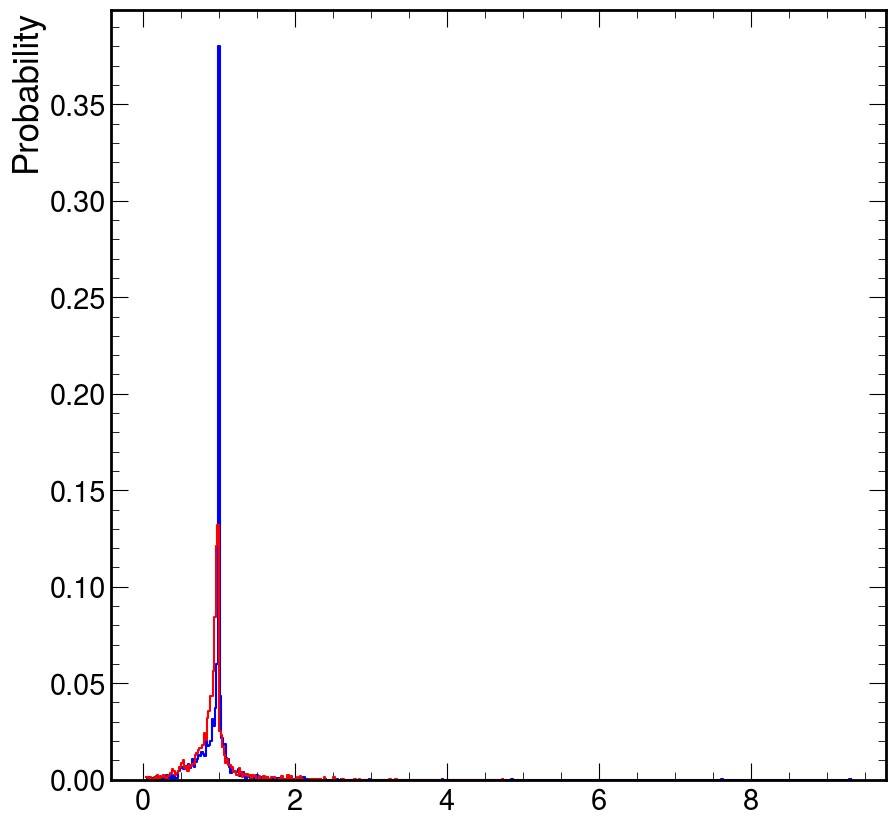

In [16]:
import seaborn as sns
sns.histplot(sd_hgb[sd_hgb.pid==-211].pred_showers_E/sd_hgb[sd_hgb.pid==-211].reco_showers_E, stat="probability",binwidth=0.02, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[sd_pandora.pid==-211].pred_showers_E/sd_pandora[sd_pandora.pid==-211].reco_showers_E, stat="probability",binwidth=0.02, color="red",  element="step",fill=False)

<Axes: xlabel='pred_showers_E', ylabel='Count'>

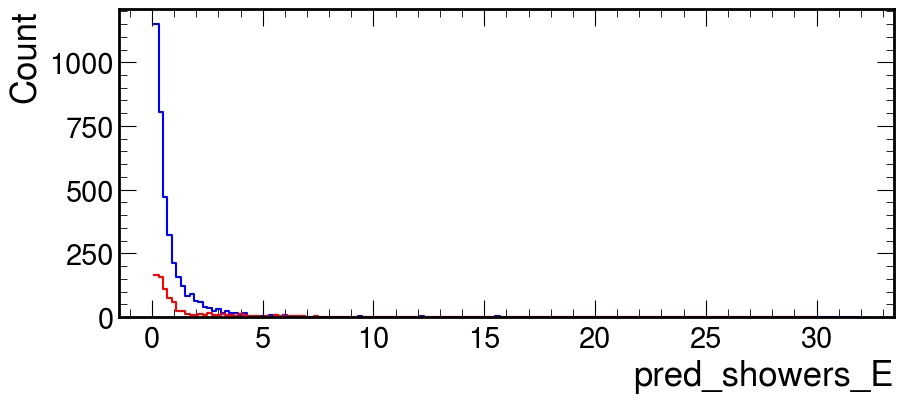

In [10]:
import seaborn as sns
plt.figure(figsize = (10,4))
sns.histplot(sd_hgb[np.isnan(sd_hgb.true_showers_E)*(sd_hgb.pred_showers_E.values>0.10)].pred_showers_E,  binwidth=0.2, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[np.isnan(sd_pandora.true_showers_E)*(sd_pandora.pred_showers_E.values>0.10)].pred_showers_E, binwidth=0.2, color="red", element="step",fill=False)
# plt.yscale('log')

<Axes: xlabel='pred_showers_E', ylabel='Count'>

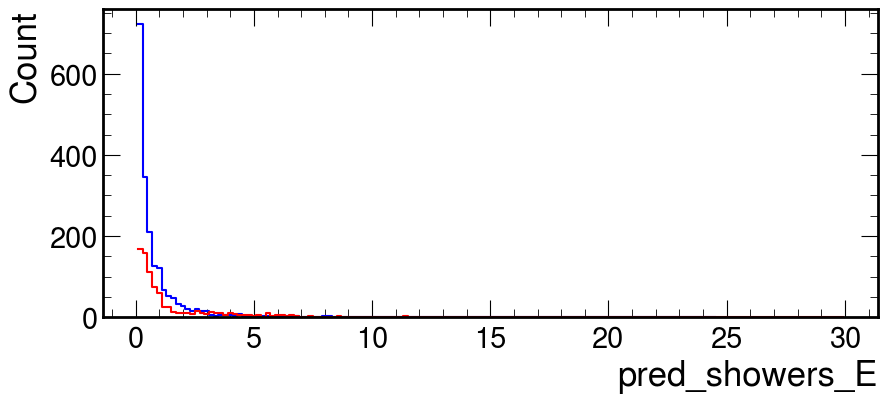

In [8]:
import seaborn as sns
plt.figure(figsize = (10,4))
sns.histplot(sd_hgb[np.isnan(sd_hgb.true_showers_E)*(sd_hgb.pred_showers_E.values>0.10)].pred_showers_E,  binwidth=0.2, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[np.isnan(sd_pandora.true_showers_E)*(sd_pandora.pred_showers_E.values>0.10)].pred_showers_E, binwidth=0.2, color="red", element="step",fill=False)
# plt.yscale('log')

In [13]:
np.sum(sd_hgb[np.isnan(sd_hgb.true_showers_E)*(sd_hgb.pred_showers_E.values>0.10)].pred_showers_E), np.sum(sd_pandora[np.isnan(sd_pandora.true_showers_E)*(sd_pandora.pred_showers_E.values>0.10)].pred_showers_E)

(3885.8972, 1350.7943)

<Axes: xlabel='pred_showers_E', ylabel='Count'>

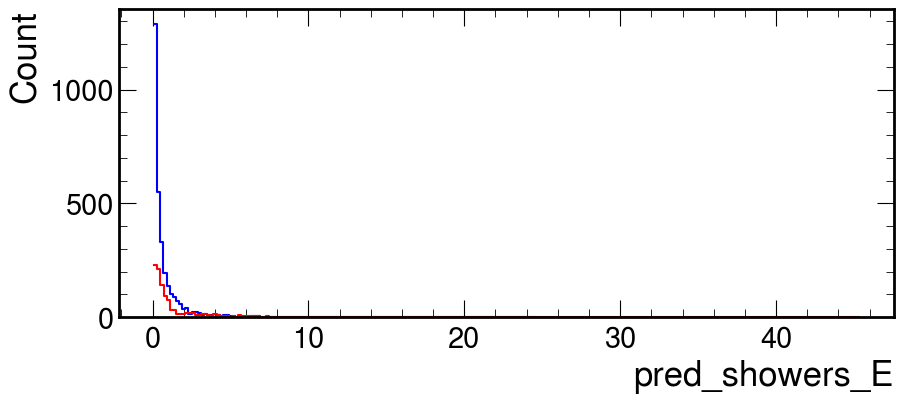

In [52]:
import seaborn as sns
plt.figure(figsize = (10,4))
sns.histplot(sd_hgb[np.isnan(sd_hgb.true_showers_E)*(sd_hgb.pred_showers_E.values>0.10)].pred_showers_E,  binwidth=0.2, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[np.isnan(sd_pandora.true_showers_E)*(sd_pandora.pred_showers_E.values>0.10)].pred_showers_E, binwidth=0.2, color="red", element="step",fill=False)
# plt.yscale('log')

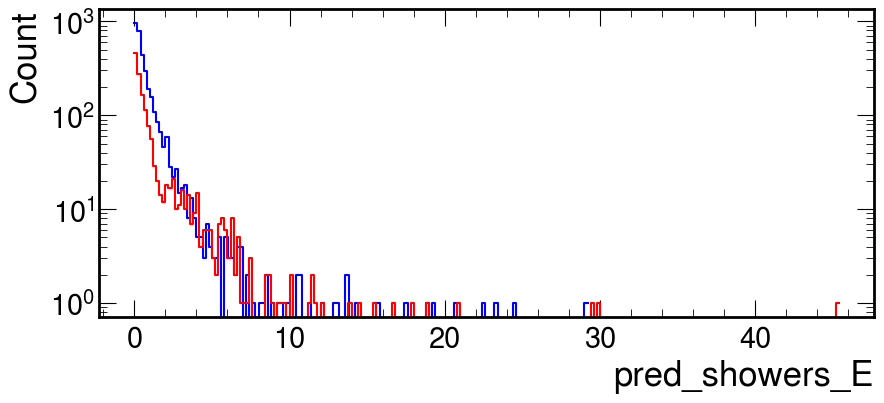

In [20]:
import seaborn as sns
plt.figure(figsize = (10,4))
sns.histplot(sd_hgb[np.isnan(sd_hgb.true_showers_E)].pred_showers_E,  binwidth=0.2, color="blue",  element="step",fill=False)
sns.histplot(sd_pandora[np.isnan(sd_pandora.true_showers_E)].pred_showers_E, binwidth=0.2, color="red", element="step",fill=False)
plt.yscale('log')

In [23]:
sd_pandora[0:30]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pandora_ref_pt,pid,step,number_batch,is_track_in_cluster,vertex,true_pos,pid_4_class_true
0,21.041212,19.520895,18.414795,18.122145,19.587936,20.879280,"[-9.336617469787598, -6.816671848297119, 17.38...","[-28.346939086914062, -21.42176055908203, 32.7...",-321.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-9.404985427856445, -6.865049839019775, 17.51...",NaN
1,3.884395,3.334723,3.229570,3.229570,5.028973,3.884083,"[-1.6500719785690308, -1.2268136739730835, 3.2...","[-28.308591842651367, -21.488067626953125, 36....",321.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-1.6388781070709229, -1.2186970710754395, 3.2...",NaN
2,4.183385,2.653735,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",321.0,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[2.852459192276001, 2.038388252258301, -2.2283...",NaN
3,23.835997,23.925354,23.520123,22.540266,23.938154,23.938154,"[-9.975537300109863, -8.3266019821167, 20.1044...","[-1178.710205078125, -984.2896728515625, 2376....",22.0,0.0,0.0,0.0,"[-0.12750683724880219, -0.7845514416694641, -1...","[-9.869407653808594, -8.231571197509766, 20.07...",3.0
4,5.380503,5.266236,5.525315,4.789964,5.623489,5.623489,"[-2.355583429336548, -1.8925384283065796, 4.74...","[-1168.6263427734375, -939.0720825195312, 2354...",22.0,0.0,0.0,0.0,"[-0.12750683724880219, -0.7845514416694641, -1...","[-2.240812301635742, -1.7979025840759277, 4.54...",3.0
5,1.216162,1.661927,1.618129,1.618129,2.154042,1.189099,"[-0.365926593542099, -0.6101782321929932, 0.94...","[-17.445560455322266, -30.64255142211914, 25.9...",-211.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-0.3731476366519928, -0.6243683695793152, 0.9...",1.0
6,0.607246,0.783801,0.777798,0.777798,0.816163,0.605844,"[0.17265479266643524, -0.08553100377321243, 0....","[11.828306198120117, -6.924165725708008, 18.86...",211.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[0.17441381514072418, -0.08467189967632294, 0....",1.0
7,0.599934,0.551861,0.519297,0.519297,0.762423,0.593281,"[-0.24412432312965393, 0.05160330981016159, 0....","[-35.260005950927734, 5.194657325744629, 54.45...",-211.0,0.0,0.0,1.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-0.24781310558319092, 0.053123150020837784, 0...",1.0
8,0.505133,0.582247,0.573116,0.573116,0.583300,0.583300,"[-0.21726974844932556, 0.28550201654434204, -0...","[-1103.95166015625, 1457.8475341796875, -2340....",22.0,0.0,0.0,0.0,"[-0.1265818476676941, -0.7837854027748108, -19...","[-0.1888885647058487, 0.2478916198015213, -0.3...",3.0
9,4.654628,3.683562,5.017897,3.353475,5.961981,5.961981,"[4.478820323944092, 2.087526559829712, -3.3358...","[2125.533447265625, 949.001220703125, -1560.17...",211.0,0.0,0.0,0.0,"[-0.12657997012138367, -0.783784031867981, -19...","[3.1898109912872314, 2.2069272994995117, -2.56...",1.0


In [2]:
# plt.plot(sd_hgb.reco_showers_E, np.exp(sd_hgb.reco_showers_E/15).values,'x')


In [60]:

def get_mask_id(id, pids_pandora):
    mask_id = np.full((len(pids_pandora)), False, dtype=bool)
    for i in id:
        mask_i = np.abs(pids_pandora) == i
        mask_id = mask_id + mask_i
    mask_id = mask_id.astype(bool)
    return mask_id
matched = matched_hgb
pids = np.abs(matched["pid"].values)
mask_id = get_mask_id([2212], pids)
matched = matched[mask_id]

matched_pandora = matched_hgbq1
pids = np.abs(matched_pandora["pid"].values)
mask_id = get_mask_id([2212], pids)
matched_pandora = matched_pandora[mask_id]

In [61]:
distribution_ml = matched.pred_showers_E.values/matched.reco_showers_E.values
mask_e_  = (matched.true_showers_E.values<5 )*(matched.true_showers_E.values>0 )
distribution_pandora = matched_pandora.pred_showers_E.values/matched_pandora.reco_showers_E.values
mask_e_p  = (matched_pandora.true_showers_E.values<5 )*(matched_pandora.true_showers_E.values>0 )

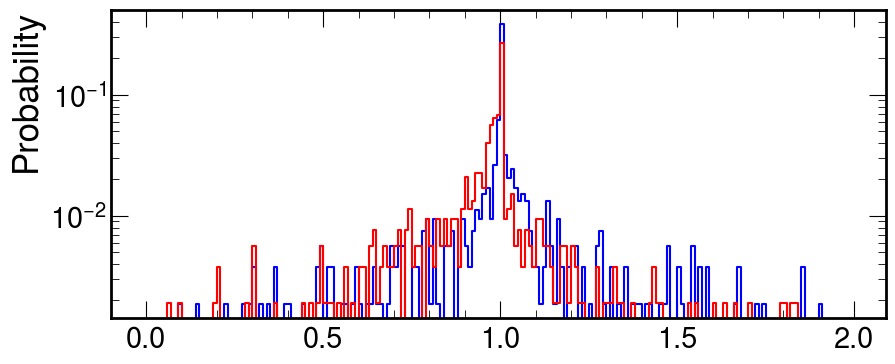

In [67]:
import seaborn as sns
binning = 1e-2
bins_per_binned_E = np.arange(0, 2, binning)
plt.figure(figsize = (10,4))
sns.histplot(distribution_ml[mask_e_], bins = bins_per_binned_E, color="blue", stat="probability", element="step",fill=False)
sns.histplot(distribution_pandora[mask_e_p],  bins = bins_per_binned_E,color="red",stat="probability", element="step",fill=False)
plt.yscale('log')

In [63]:
binning = 1e-2
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit
bins_per_binned_E = np.arange(0, 2, binning)
e_over_reco = distribution_ml[mask_e_]
hist, bin_edges = np.histogram(e_over_reco, bins=bins_per_binned_E, density=True)
# Calculating the Gaussian PDF values given Gaussian parameters and random variable X
def gaus(X, C, X_mean, sigma):
    return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))
n = len(hist)
x_hist = np.zeros((n), dtype=float)
for ii in range(n):
    x_hist[ii] = (bin_edges[ii + 1] + bin_edges[ii]) / 2
y_hist = hist

mean = sum(x_hist * y_hist) / sum(y_hist)
sigma = sum(y_hist * (x_hist - mean) ** 2) / sum(y_hist)


param_optimised, param_covariance_matrix = curve_fit(
    gaus, x_hist, y_hist, p0=[max(y_hist), mean, sigma], maxfev=10000
)

param_optimised[1], param_optimised[2] / param_optimised[1]

/tmp/mgarciam/ipykernel_325257/3519669631.py:9: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))


(1.0042348868768056, 0.004792385677439974)

In [64]:
binning = 1e-2
from scipy import asarray as ar, exp
from scipy.optimize import curve_fit
bins_per_binned_E = np.arange(0, 2, binning)
e_over_reco = distribution_pandora[mask_e_p]
hist, bin_edges = np.histogram(e_over_reco, bins=bins_per_binned_E, density=True)
# Calculating the Gaussian PDF values given Gaussian parameters and random variable X
def gaus(X, C, X_mean, sigma):
    return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))
n = len(hist)
x_hist = np.zeros((n), dtype=float)
for ii in range(n):
    x_hist[ii] = (bin_edges[ii + 1] + bin_edges[ii]) / 2
y_hist = hist

mean = sum(x_hist * y_hist) / sum(y_hist)
sigma = sum(y_hist * (x_hist - mean) ** 2) / sum(y_hist)


param_optimised, param_covariance_matrix = curve_fit(
    gaus, x_hist, y_hist, p0=[max(y_hist), mean, sigma], maxfev=10000
)
param_optimised[1], param_optimised[2] / param_optimised[1]

/tmp/mgarciam/ipykernel_325257/3768993754.py:9: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  return C * exp(-((X - X_mean) ** 2) / (2 * sigma**2))


(1.0029600886987877, 0.004656101483621895)

In [9]:
matched = matched_pandora
# bins = np.arange(0, 51, 6)
from src.utils.inference.per_particle_metrics import  get_sigma_gaussian
bins = [0, 5, 15, 35, 50]
mean = []
variance_om = []
mean_baseline = []
variance_om_baseline = []
mean_true_rec = []
variance_om_true_rec = []
mean_errors = []
variance_om_errors = []
energy_resolutions = []
energy_resolutions_reco = []
distributions = []  # distributions of E/Etrue for plotting later
mean_pxyz = []
variance_pxyz = []
masses = []
is_track_in_cluster = []
pxyz_true, pxyz_pred = [], []
sigma_phi, sigma_theta = [], [] # for the angular resolution vs. energy
distr_phi, distr_theta = [], []

binning = 1e-2
bins_per_binned_E = np.arange(0, 2, binning)
for i in range(len(bins) - 1):
    bin_i = bins[i]
    bin_i1 = bins[i + 1]
    mask_above = matched["true_showers_E"] <= bin_i1
    mask_below = matched["true_showers_E"] > bin_i
    mask_check = matched["pred_showers_E"] > 0
    mask = mask_below * mask_above * mask_check
    print("sum mas", np.sum(mask))
    true_e = matched.true_showers_E[mask]
    true_rec = matched.reco_showers_E[mask]

    pred_e_nocor = matched.pred_showers_E[mask]
    true_pxyz = np.array(matched.true_pos[mask].tolist())
    bins_angle = np.linspace(-0.1, +0.1, 400)
    if np.sum(mask) > 0:  # if the bin is not empty
        e_over_reco = true_rec / true_e
        e_over_reco_ML = pred_e_nocor / true_rec
        
        (
            mean_reco_ML,
            var_reco_ML,
            err_mean_reco_ML,
            err_mean_var_reco_ML,
        ) = get_sigma_gaussian(e_over_reco_ML, bins_per_binned_E)
        print("mean_reco_ML", mean_reco_ML)
       
      
        mean_true_rec.append(mean_reco_ML)
        variance_om_true_rec.append(np.abs(var_reco_ML))
     

sum mas 7739
mean_reco_ML 0.968075301987698
sum mas 837
mean_reco_ML 0.9754916337248599
sum mas 118
mean_reco_ML 0.9790731083128748
sum mas 0


In [10]:
variance_om_true_rec

[0.024486182072803606, 0.01932306692028565, 0.032195650774175896]

In [12]:
variance_om_true_rec

[]

In [11]:
bins = [0, 5, 15, 35, 50]
mean = []
variance_om = []
mean_baseline = []
variance_om_baseline = []
mean_true_rec = []
variance_om_true_rec = []
mean_errors = []
variance_om_errors = []
energy_resolutions = []
energy_resolutions_reco = []
distributions = []  # distributions of E/Etrue for plotting later
mean_pxyz = []
variance_pxyz = []
masses = []
is_track_in_cluster = []
pxyz_true, pxyz_pred = [], []
sigma_phi, sigma_theta = [], [] # for the angular resolution vs. energy
distr_phi, distr_theta = [], []
#distribution_slice_5_6_GeV = []
# tic = time.time()
# vector = range(len(bins) - 1)
# output_results = parallel_process(vector, bins, matched, pandora, bins_per_binned_E)
# mean_true_rec = [r[0] for ind, r in enumerate(output_results)]
# variance_om_true_rec = [r[1] for ind, r in enumerate(output_results)]
# energy_resolutions_reco = [r[2] for ind, r in enumerate(output_results)]
# toc = time.time()
# print("time with paralel version", toc - tic)
print("START PANDORA")
binning = 1e-2
bins_per_binned_E = np.arange(0, 2, binning)
for i in range(len(bins) - 1):
    bin_i = bins[i]
    bin_i1 = bins[i + 1]
    mask_above = matched["true_showers_E"] <= bin_i1
    mask_below = matched["true_showers_E"] > bin_i
    mask_check = matched["pred_showers_E"] > 0
    mask = mask_below * mask_above * mask_check
    print("sum mas", np.sum(mask))

START PANDORA
sum mas 7739
sum mas 837
sum mas 118
sum mas 0


In [3]:
# reduced_p = sd_pandora[sd_pandora.pid==130]
# reduced_p[np.isnan(reduced_p.pred_showers_E)]

In [13]:
def calculate_eff(sd, log_scale=False):
    if log_scale:
        bins = np.exp(np.arange(np.log(0.1), np.log(80), 0.3))
    else:
        bins = np.arange(0, 51, 5)
    eff = []
    energy_eff = []
    errors = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = sd.reco_showers_E.values <= bin_i1
        mask_below = sd.reco_showers_E.values > bin_i
        mask = mask_below * mask_above
        number_of_non_reconstructed_showers = np.sum(
            np.isnan(sd.pred_showers_E.values)[mask]
        )
        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            eff.append(
                (total_showers - number_of_non_reconstructed_showers) / total_showers
            )
            energy_eff.append((bin_i1 + bin_i) / 2)
            n_total = total_showers
            n_r = total_showers - number_of_non_reconstructed_showers
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            print(total_showers, n_r, error)
            error = np.sqrt(error)
            errors.append(error)
    return eff, energy_eff, errors

def create_eff_dic(photons_dic, matched_, id, var_i):
    pids = np.abs(matched_["pid"].values)
    mask_id = pids == id
    df_id = matched_[mask_id]

    eff, energy_eff, errors = calculate_eff(df_id, False)
    photons_dic["eff_" + str(var_i)] = eff
    photons_dic["energy_eff_" + str(var_i)] = energy_eff
    photons_dic["errors" + str(var_i)] = errors
    return photons_dic

def create_eff_dic_pandora(matched_pandora, id):
    pids_pandora = np.abs(matched_pandora["pid"].values)
    mask_id = pids_pandora == id
    df_id_pandora = matched_pandora[mask_id]
    eff_p, energy_eff_p, errors = calculate_eff(df_id_pandora, False)
    photons_dic = {}
    photons_dic["eff_p"] = eff_p
    photons_dic["energy_eff_p"] = energy_eff_p
    photons_dic["errors_p"] = errors
    return photons_dic

In [14]:
# from src.utils.inference.per_particle_metrics import create_eff_dic_pandora, create_eff_dic
photons_dic = create_eff_dic_pandora(sd_pandora, 22)
electrons_dic = create_eff_dic_pandora(sd_pandora, 11)
pions_dic = create_eff_dic_pandora(sd_pandora, 211)
kaons_dic = create_eff_dic_pandora(sd_pandora, 130)

var_i = "0"
photons_dic = create_eff_dic(photons_dic, sd_hgb, 22, var_i=var_i)
electrons_dic = create_eff_dic(electrons_dic, sd_hgb, 11, var_i=var_i)
pions_dic = create_eff_dic(pions_dic, sd_hgb, 211, var_i=var_i)
kaons_dic = create_eff_dic(kaons_dic, sd_hgb, 130, var_i=var_i)


8682 7724 0.00019363578826451215
657 607 0.002705450898850806
241 233 0.007890111399011296
83 80 0.022805695127731136
34 33 0.05625381640545492
11 9 0.13523666416228397
8 8 0.25000000000000006
1377 1113 0.0010614332564319027
81 72 0.020728547477518663
17 17 0.11764705882352941
3 3 0.6666666666666666
2 2 1.0000000000000002
3 3 0.6666666666666666
5511 4914 0.000306069449717713
1159 1068 0.0015277108457167916
464 431 0.0038614139731282544
244 224 0.007216463051973513
125 119 0.014866431999999999
62 61 0.031481823369474
27 27 0.07407407407407408
13 13 0.15384615384615385
4 4 0.5
246 182 0.005232507213035645
126 92 0.01002611509036301
114 93 0.012993876658405014
75 62 0.02013392592592593
70 68 0.02735860058309038
63 62 0.030994173095458058
29 28 0.06543933740620772
24 24 0.08333333333333331
15 15 0.13333333333333336
8 8 0.25000000000000006
8682 8353 0.0002174329082739104
657 635 0.002892944688595054
241 235 0.007991415051279437
83 81 0.02323242745987579
34 34 0.05882352941176471
11 9 0.1352

(0.55, 1.05)

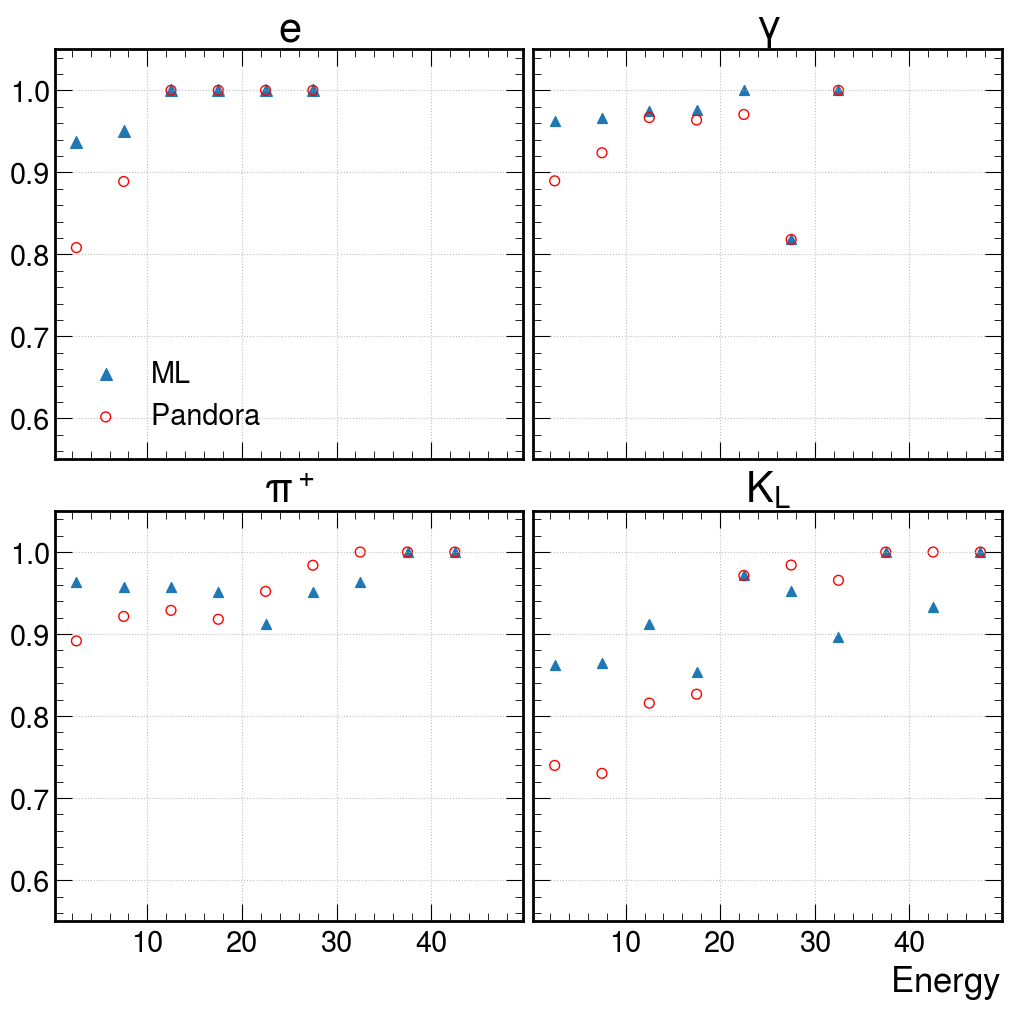

In [15]:
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
markers = ["^", "*", "x", "d", ".", "s"]
i =0
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, layout="constrained")
axs[0, 0].scatter(
            electrons_dic["energy_eff_" + str(i)],
            electrons_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=70,
        )
# axs[0, 0].errorbar(electrons_dic["energy_eff_" + str(i)], electrons_dic["eff_" + str(i)] ,yerr= electrons_dic["errors" + str(i)], linestyle='none')

axs[0, 0].scatter(
    electrons_dic["energy_eff_p"],
    electrons_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
# axs[0, 0].errorbar(electrons_dic["energy_eff_p"], electrons_dic["eff_p"] ,yerr= electrons_dic["errors_p"], linestyle='none')

axs[0, 0].set_title("$e$")
axs[0,0].set_ylim([0.55,1.05])
axs[0,0].grid()
axs[0,0].legend()
axs[0, 1].scatter(
            photons_dic["energy_eff_" + str(i)],
            photons_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=50,
        )
# axs[0, 1].errorbar(photons_dic["energy_eff_" + str(i)], photons_dic["eff_" + str(i)] ,yerr= photons_dic["errors" + str(i)], linestyle='none')

axs[0, 1].scatter(
    photons_dic["energy_eff_p"],
    photons_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
# axs[0, 1].errorbar(photons_dic["energy_eff_p"], photons_dic["eff_p"] ,yerr= photons_dic["errors_p"], linestyle='none')

axs[0, 1].set_title("$\\gamma$")
axs[0, 1].set_ylim([0.55,1.05])
axs[0, 1].grid()
axs[1, 0].scatter(
            pions_dic["energy_eff_" + str(i)],
            pions_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=50,
        )
axs[1, 0].scatter(
    pions_dic["energy_eff_p"],
    pions_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
axs[1, 0].set_title("$\\pi^+$")
axs[1, 0].set_ylim([0.55,1.05])
axs[1, 0].grid()
axs[1, 1].scatter(
            kaons_dic["energy_eff_" + str(i)],
            kaons_dic["eff_" + str(i)],
            label="ML", 
            marker=markers[i],
            s=50,
        )
# axs[1, 1].errorbar(kaons_dic["energy_eff_" + str(i)], kaons_dic["eff_" + str(i)] ,yerr= kaons_dic["errors" + str(i)], linestyle='none')

axs[1, 1].scatter(
    kaons_dic["energy_eff_p"],
    kaons_dic["eff_p"],
    facecolors='none',
    edgecolors="r",
    label="Pandora " ,
    marker="o",
    s=50,
)
# axs[1, 1].errorbar(kaons_dic["energy_eff_p"], kaons_dic["eff_p"] ,yerr= kaons_dic["errors_p"], linestyle='none')

axs[1, 1].set_title("$K_L$")
axs[1, 1].set_xlabel("$Energy$")
axs[1, 1].grid()
axs[1, 1].set_ylim([0.55,1.05])